In [1]:
from ml_final_project.config import PROCESSED_DATA_DIR
import polars as pl


data = pl.scan_parquet(PROCESSED_DATA_DIR / "CivilServiceCommission" / "civilservicecommission-2.parquet")

2025-05-13 11:57:34.624 | INFO     | ml_final_project.config:<module>:11 - PROJ_ROOT path is: D:\Documents\3 Production Save Files\1 Cloned repositories\ml-final-project


In [2]:
position_titles: pl.LazyFrame = data.select([pl.col("Position Title")])

In [3]:
from datasets import Dataset
from transformers import BertTokenizer

titles = ["Senior Software Engineer", "Lead Data Scientist", "UX Designer"]
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Format data
dataset = Dataset.from_dict({"text": list(position_titles.collect().to_numpy().ravel())})

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=32)

tokenized_dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/110244 [00:00<?, ? examples/s]

In [4]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)


In [5]:
from transformers import BertForMaskedLM, Trainer, TrainingArguments

model = BertForMaskedLM.from_pretrained("bert-base-uncased")

training_args = TrainingArguments(
    output_dir="./bert-jobtitles",
    eval_strategy="no",
    per_device_train_batch_size=16,
    num_train_epochs=3,
    save_steps=500,
    save_total_limit=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\Andrei\AppData\Local\Temp\ipykernel_20728\3553926853.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
d:\Documents\3 Production Save Files\1 Cloned repositories\ml-final-project\.venv\Lib\sit

Step,Training Loss
500,1.823200
1000,1.254800
1500,1.095100
2000,0.991600
2500,0.948700
3000,0.905600
3500,0.886000
4000,0.853200
4500,0.799900
5000,0.808400


d:\Documents\3 Production Save Files\1 Cloned repositories\ml-final-project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\Documents\3 Production Save Files\1 Cloned repositories\ml-final-project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=20673, training_loss=0.7335336582123129, metrics={'train_runtime': 39959.3163, 'train_samples_per_second': 8.277, 'train_steps_per_second': 0.517, 'total_flos': 5440640884185600.0, 'train_loss': 0.7335336582123129, 'epoch': 3.0})

In [6]:
trainer.save_model("./bert-jobtitles-adapted")
tokenizer.save_pretrained("./bert-jobtitles-adapted")


('./bert-jobtitles-adapted\\tokenizer_config.json',
 './bert-jobtitles-adapted\\special_tokens_map.json',
 './bert-jobtitles-adapted\\vocab.txt',
 './bert-jobtitles-adapted\\added_tokens.json')

In [33]:
from ml_final_project.config import PROJ_ROOT, PROCESSED_DATA_DIR, INTERIM_DATA_DIR
import torch

In [27]:
from transformers import BertTokenizer, BertModel

model_path = PROJ_ROOT / "notebooks" / "bert-jobtitles-adapted" # or the path you used in TrainingArguments

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertModel.from_pretrained(model_path)  # ⚠️ Note: using BertModel here

Some weights of BertModel were not initialized from the model checkpoint at D:\Documents\3 Production Save Files\1 Cloned repositories\ml-final-project\notebooks\bert-jobtitles-adapted and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
def get_cls_embedding(text, tokenizer, model):
    """
    Generate CLS embedding for a given text using a pre-trained BERT model.

    Parameters:
    - text (str): The input text to encode.
    - tokenizer (transformers.BertTokenizer): The tokenizer for the BERT model.
    - model (transformers.BertModel): The pre-trained BERT model.

    Returns:
    - torch.Tensor: The CLS embedding of the input text.
    """
    # Tokenize and convert to input IDs
    inputs = tokenizer(text, return_tensors='pt')

    # Forward pass through BERT
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the last hidden state (sequence output)
    last_hidden_state = outputs.last_hidden_state  # shape: [1, seq_len, hidden_size]

    # To get sentence embedding, use the [CLS] token (first token)
    cls_embedding = last_hidden_state[0, 0]  # shape: [hidden_size]
    return cls_embedding.sum()

In [42]:
get_cls_embedding("Senior Software Engineer", tokenizer, model)

tensor(-6.8373)

In [37]:
data = pl.read_parquet(PROCESSED_DATA_DIR / "CivilServiceCommission" / "civilservicecommission-unclean-training-data.parquet")
# embedded_data = pl.read_csv(INTERIM_DATA_DIR / "CivilServiceCommission" / "civilservicecommission-filtered-embedded.parquet")

In [38]:
data

jobId,Agency,Region,PlaceOfAssignment,Posting Date,Closing Date,Position Title,SalaryGrade,MonthlySalary,Eligibility,Education,Training,Experience,Competency,Plantilla Item No.,positiontitle_embedding,agency_embedding,education_embedding,experience_embedding,eligibility_embedding,salarygrade_embedding,experience_years
i64,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f32
4235342,"""BICOL MEDICAL CENTER""","""Region V""","""Division Office, Division of A…","""2024-12-06""","""2024-12-16""","""NURSE III""","""14""",33843,"""PBET/LET/RA1080 Teacher""","""Bachelor's degree in""","""None Required""","""None Required""","""N/A""","""OSEC-DOHB-NURS3-390074-2015""",-7.324668,-7.893728,-7.534733,-8.596694,-7.49356,-8.301358,0.0
4267059,"""COTABATO REGIONAL AND MEDICAL …","""Region XII""","""PETDU-CRMC Cotabato City""","""2025-01-08""","""2025-01-18""","""Training Specialist II""","""15""",38413,"""Career Service Professional/Se…","""Bachelor'S Degree""","""Specialist II""","""1 Year Of Relevant""","""""","""OSEC-DOHB-TRNSP2-840012-2024""",-6.994604,-7.494605,-8.148396,-6.840691,-7.659439,-8.37644,1.0
4325512,"""DEPARTMENT OF EDUCATION""","""Region XII""","""ELEMENTARY- SDO SULTAN KUDARAT""","""2025-02-07""","""2025-02-17""","""Head Teacher IV""","""17""",47247,"""RA 1080, as amended (Teacher)""","""Bachelor's degree in Elementar…","""24 hours of relevant training""","""HT for 3 years; or MT for 2 ye…","""""","""OSEC-DECSB-HTEACH4-840037-2021""",-7.060712,-9.257008,-7.813778,-6.978828,-7.597981,-8.679143,2.5
4347023,"""MANILA, NCR""","""NCR""","""ELEMENTARY SCHOOLS""","""2025-02-19""","""2025-03-03""","""TEACHER III""","""13""",34421,"""RA 1080 (TEACHER)""","""BEED or Bachelor's Degree plus…","""None Required""","""2 years of relevant experience""","""Not Applicable""","""OSEC-DECSB-TCH3-33077-1998""",-7.144463,-7.815163,-6.617424,-7.69224,-7.368425,-8.287629,2.0
4318456,"""DEPARTMENT OF EDUCATION""","""Region XI""","""Sta. Cruz National High School""","""2025-02-04""","""2025-02-14""","""MASTER TEACHER I (Secondary Gr…","""18""",51304,"""PBET/Teacher/RA 1080""","""Bachelor of Secondary""","""None Required""","""3 Years Relevant""","""N/A""","""OSEC-DECSB-MTCHR1-750206-2021""",-6.430348,-9.257008,-7.452889,-7.33181,-6.765957,-8.259463,3.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
4247090,"""DEPARTMENT OF EDUCATION""","""Region IV""","""Schools Division of Lipa City …","""2024-12-17""","""2024-12-27""","""Teacher II""","""12""",30705,"""RA 1080, Teacher""","""Bachelor of Secondary""","""None Required""","""1 year of relevant experience""","""N/A""","""OSEC-DECSB-TCH2-240048-2001""",-7.142153,-9.257008,-7.452889,-7.732252,-7.570666,-7.962153,1.0
4319185,"""BUREAU OF CORRECTIONS""","""NCR""","""Bureau of Corrections""","""2025-01-14""","""2025-01-24""","""Corrections Officer I""","""11""",29668,"""RA 1080/ CS Professional/ CSC …","""Bachelor's Degree""","""None required""","""None required""","""N/A""","""BCORB-CO1-890-2024""",-7.061832,-7.387201,-8.148396,-8.596694,-7.173544,-7.792544,0.0
4365994,"""DEPARTMENT OF EDUCATION""","""Region V""","""Elementary""","""2025-02-24""","""2025-03-07""","""Teacher III""","""13""",34421,"""RA 1080 (Teacher)""","""Bachelor of Elementary""","""None Required""","""2 years relevant experience""","""N/A""","""OSEC-DECSB-TCH3-391749-2020""",-7.144463,-9.257008,-7.199483,-7.627974,-7.368425,-8.287629,2.0


In [45]:
test_data = data.with_columns(pl.col("Position Title").map_elements(lambda x: get_cls_embedding(x, tokenizer, model)).alias("positiontitle_embedding"))

C:\Users\Andrei\AppData\Local\Temp\ipykernel_20728\3395952824.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  test_data = data.with_columns(pl.col("Position Title").map_elements(lambda x: get_cls_embedding(x, tokenizer, model)).alias("positiontitle_embedding"))


In [ ]:

test_data

jobId,Agency,Region,PlaceOfAssignment,Posting Date,Closing Date,Position Title,SalaryGrade,MonthlySalary,Eligibility,Education,Training,Experience,Competency,Plantilla Item No.,positiontitle_embedding,agency_embedding,education_embedding,experience_embedding,eligibility_embedding,salarygrade_embedding,experience_years
i64,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f32
4235342,"""BICOL MEDICAL CENTER""","""Region V""","""Division Office, Division of A…","""2024-12-06""","""2024-12-16""","""NURSE III""","""14""",33843,"""PBET/LET/RA1080 Teacher""","""Bachelor's degree in""","""None Required""","""None Required""","""N/A""","""OSEC-DOHB-NURS3-390074-2015""",-6.958827,-7.893728,-7.534733,-8.596694,-7.49356,-8.301358,0.0
4267059,"""COTABATO REGIONAL AND MEDICAL …","""Region XII""","""PETDU-CRMC Cotabato City""","""2025-01-08""","""2025-01-18""","""Training Specialist II""","""15""",38413,"""Career Service Professional/Se…","""Bachelor'S Degree""","""Specialist II""","""1 Year Of Relevant""","""""","""OSEC-DOHB-TRNSP2-840012-2024""",-6.890889,-7.494605,-8.148396,-6.840691,-7.659439,-8.37644,1.0
4325512,"""DEPARTMENT OF EDUCATION""","""Region XII""","""ELEMENTARY- SDO SULTAN KUDARAT""","""2025-02-07""","""2025-02-17""","""Head Teacher IV""","""17""",47247,"""RA 1080, as amended (Teacher)""","""Bachelor's degree in Elementar…","""24 hours of relevant training""","""HT for 3 years; or MT for 2 ye…","""""","""OSEC-DECSB-HTEACH4-840037-2021""",-6.772378,-9.257008,-7.813778,-6.978828,-7.597981,-8.679143,2.5
4347023,"""MANILA, NCR""","""NCR""","""ELEMENTARY SCHOOLS""","""2025-02-19""","""2025-03-03""","""TEACHER III""","""13""",34421,"""RA 1080 (TEACHER)""","""BEED or Bachelor's Degree plus…","""None Required""","""2 years of relevant experience""","""Not Applicable""","""OSEC-DECSB-TCH3-33077-1998""",-6.761898,-7.815163,-6.617424,-7.69224,-7.368425,-8.287629,2.0
4318456,"""DEPARTMENT OF EDUCATION""","""Region XI""","""Sta. Cruz National High School""","""2025-02-04""","""2025-02-14""","""MASTER TEACHER I (Secondary Gr…","""18""",51304,"""PBET/Teacher/RA 1080""","""Bachelor of Secondary""","""None Required""","""3 Years Relevant""","""N/A""","""OSEC-DECSB-MTCHR1-750206-2021""",-6.923392,-9.257008,-7.452889,-7.33181,-6.765957,-8.259463,3.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
4247090,"""DEPARTMENT OF EDUCATION""","""Region IV""","""Schools Division of Lipa City …","""2024-12-17""","""2024-12-27""","""Teacher II""","""12""",30705,"""RA 1080, Teacher""","""Bachelor of Secondary""","""None Required""","""1 year of relevant experience""","""N/A""","""OSEC-DECSB-TCH2-240048-2001""",-6.548726,-9.257008,-7.452889,-7.732252,-7.570666,-7.962153,1.0
4319185,"""BUREAU OF CORRECTIONS""","""NCR""","""Bureau of Corrections""","""2025-01-14""","""2025-01-24""","""Corrections Officer I""","""11""",29668,"""RA 1080/ CS Professional/ CSC …","""Bachelor's Degree""","""None required""","""None required""","""N/A""","""BCORB-CO1-890-2024""",-6.973213,-7.387201,-8.148396,-8.596694,-7.173544,-7.792544,0.0
4365994,"""DEPARTMENT OF EDUCATION""","""Region V""","""Elementary""","""2025-02-24""","""2025-03-07""","""Teacher III""","""13""",34421,"""RA 1080 (Teacher)""","""Bachelor of Elementary""","""None Required""","""2 years relevant experience""","""N/A""","""OSEC-DECSB-TCH3-391749-2020""",-6.761898,-9.257008,-7.199483,-7.627974,-7.368425,-8.287629,2.0


In [4]:
# step1 = test_data.filter(pl.col("MonthlySalary") > 100)

# q1 = step1["MonthlySalary"].quantile(0.25)
# q3 = step1["MonthlySalary"].quantile(0.75)
# iqr = q3 - q1

# step2 = step1.filter(
#         (pl.col("MonthlySalary") >= q1 - 1.5 * iqr)
#         & (pl.col("MonthlySalary") <= q3 + 1.5 * iqr)
#     )

# processed_df_2 = step2
processed_df_2 = pl.read_parquet(PROCESSED_DATA_DIR / "CivilServiceCommission" / "civilservicecommission-embedded-training-data-(finetuned-position).parquet")
train_data = processed_df_2.select(
    [
        pl.col("positiontitle_embedding"),
        pl.col("agency_embedding"),
        pl.col("education_embedding"),
        pl.col("experience_years"),
        pl.col("eligibility_embedding"),
        pl.col("MonthlySalary"),
    ]
)

In [5]:
train_data

positiontitle_embedding,agency_embedding,education_embedding,experience_years,eligibility_embedding,MonthlySalary
f64,f64,f64,f32,f64,i64
-6.958827,-7.893728,-7.534733,0.0,-7.49356,33843
-6.890889,-7.494605,-8.148396,1.0,-7.659439,38413
-6.772378,-9.257008,-7.813778,2.5,-7.597981,47247
-6.761898,-7.815163,-6.617424,2.0,-7.368425,34421
-6.923392,-9.257008,-7.452889,3.0,-6.765957,51304
…,…,…,…,…,…
-6.548726,-9.257008,-7.452889,1.0,-7.570666,30705
-6.973213,-7.387201,-8.148396,0.0,-7.173544,29668
-6.761898,-9.257008,-7.199483,2.0,-7.368425,34421


In [73]:
processed_df_2.write_parquet(PROCESSED_DATA_DIR / "CivilServiceCommission" / "civilservicecommission-embedded-training-data-(finetuned-position).parquet")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

X = train_data.drop("MonthlySalary").to_numpy()
y = train_data.select("MonthlySalary").to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


best_knn_model = KNeighborsRegressor(metric="manhattan", n_neighbors=11)
best_knn_model.fit(X_train, y_train)

best_preds = best_knn_model.predict(X_test)

# print_results(y_test, best_preds, "Best KNN Model (Just Right)")
# print_results(y_test, overfitting_model.predict(X_test), "Overfitting KNN Model")
best_knn_model.score(X_test, y_test)

0.8781832530757797

100%|██████████| 100/100 [00:51<00:00,  1.93it/s]

0.878633974984361 0.0031888939495389587


(array([ 1.,  2.,  0.,  1.,  1.,  6.,  5., 10.,  6.,  8.,  8., 11.,  9.,
        11.,  5.,  8.,  3.,  2.,  1.,  2.]),
 array([0.86983322, 0.87064384, 0.87145446, 0.87226508, 0.8730757 ,
        0.87388632, 0.87469694, 0.87550756, 0.87631818, 0.8771288 ,
        0.87793942, 0.87875004, 0.87956066, 0.88037128, 0.8811819 ,
        0.88199252, 0.88280314, 0.88361376, 0.88442438, 0.88523499,
        0.88604561]),
 <BarContainer object of 20 artists>)

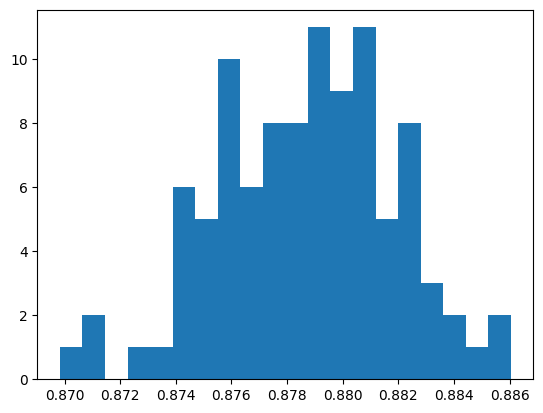

In [9]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

results = []

test_model = KNeighborsRegressor(metric="manhattan", n_neighbors=11)

for i in tqdm(range(0, 100)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    test_model.fit(X_train, y_train)
    score = test_model.score(X_test, y_test)
    results.append(score)

print(np.mean(results), np.std(results))
plt.hist(results, bins=20)